In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import logsumexp
from copy import deepcopy
import scienceplots
plt.style.use(['science', 'no-latex', 'bright'])

from ipy_oxdna.umbrella_sampling import ComUmbrellaSampling, MeltingUmbrellaSampling
from ipy_oxdna.oxdna_simulation import SimulationManager, Simulation, Observable
from ipy_oxdna.vmmc import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Initalize 8nt duplex melting unrestained Umbrella object

In [2]:
path = os.path.abspath('/scratch/matthew/ipy_oxDNA/ipy_oxdna_examples/duplex_melting/')

system_name = 'all_observables_runs'

condition = ['52C']

systems = [f'{temp}' for temp in condition]

file_dirs = [f'{path}/{system_name}' for _ in range(len(systems))]

# temperature = '52C'

com_list = '8,9,10,11,12,13,14,15'
ref_list = '7,6,5,4,3,2,1,0'
xmin = 0
xmax = 15
n_windows = 56
starting_r0 = 1
print_every = 1e4
stiff = 5
obs_filename = 'all_observables.txt'
hb_contact_filename = 'hb_contacts.txt'

pre_eq_steps = 1e6
eq_steps = 5e6
prod_steps = 2e8

particle_indexes = [com_list, ref_list]
hb_contact_observable = [{'idx':particle_indexes, 'name':f'{hb_contact_filename}', 'print_every':int(print_every)}]


pre_equlibration_parameters_list = [{'backend':'CPU','steps':f'{pre_eq_steps}','print_energy_every': f'{pre_eq_steps}',
                           'print_conf_interval':f'{pre_eq_steps}', "CUDA_list": "no",
                           'use_edge': 'false', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'fix_diffusion_every': '1000',
                           'T':f'{temperature}'} for temperature in condition]

equlibration_parameters_list = [{'backend':'CPU','steps':f'{eq_steps}','print_energy_every': f'{eq_steps}',
                           'print_conf_interval':f'{eq_steps}', "CUDA_list": "no",
                           'use_edge': 'false', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'fix_diffusion_every': '1000',
                           'T':f'{temperature}'} for temperature in condition]

production_parameters_list = [{'backend':'CPU', 'steps':f'{prod_steps}','print_energy_every': f'{prod_steps}',
                        'print_conf_interval':f'{prod_steps}', "CUDA_list": "no",
                        'use_edge': 'false', 'refresh_vel': '1',
                        'fix_diffusion': '0', 'fix_diffusion_every': '1000',
                        'T':f'{temperature}'} for temperature in condition]

us_list = [MeltingUmbrellaSampling(file_dir, sys, clean_build='force') for file_dir, sys in zip(file_dirs,systems)]

simulation_manager = SimulationManager()

# Read umbrella data into memory

In [4]:
for us in us_list:
    us.observables_list = []
    us.initialize_observables(com_list, ref_list, print_every=print_every, name=obs_filename)

all_observables = []
for us in us_list:
    all_observables.append(us.analysis.read_all_observables('prod'))

# Plot Umbrella Data 

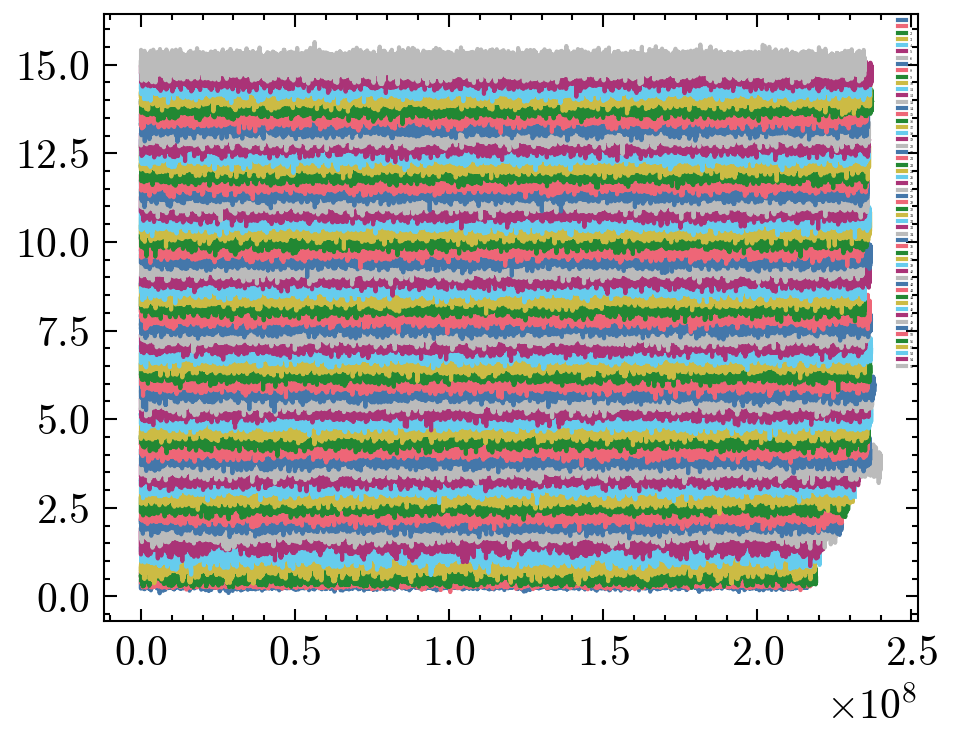

In [5]:
names = ['backbone', 'bonded_excluded_volume', 'stacking', 'nonbonded_excluded_volume', 'hydrogen_bonding', 'cross_stacking', 'coaxial_stacking', 'debye_huckel']
columns = ['com_distance', 'hb_list', 'force_energy', *names]


fig, ax = plt.subplots(dpi=300)
for idx, obs in enumerate(us_list[0].obs_df):
    plt.plot(obs['steps'], obs['com_distance'].rolling(window=1).mean(), label=f'{idx}')
plt.legend(fontsize=1)

# Initalize Ground Truth 8 nt melting Data from vmmc

/home/matthew/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2162: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/matthew/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2163: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


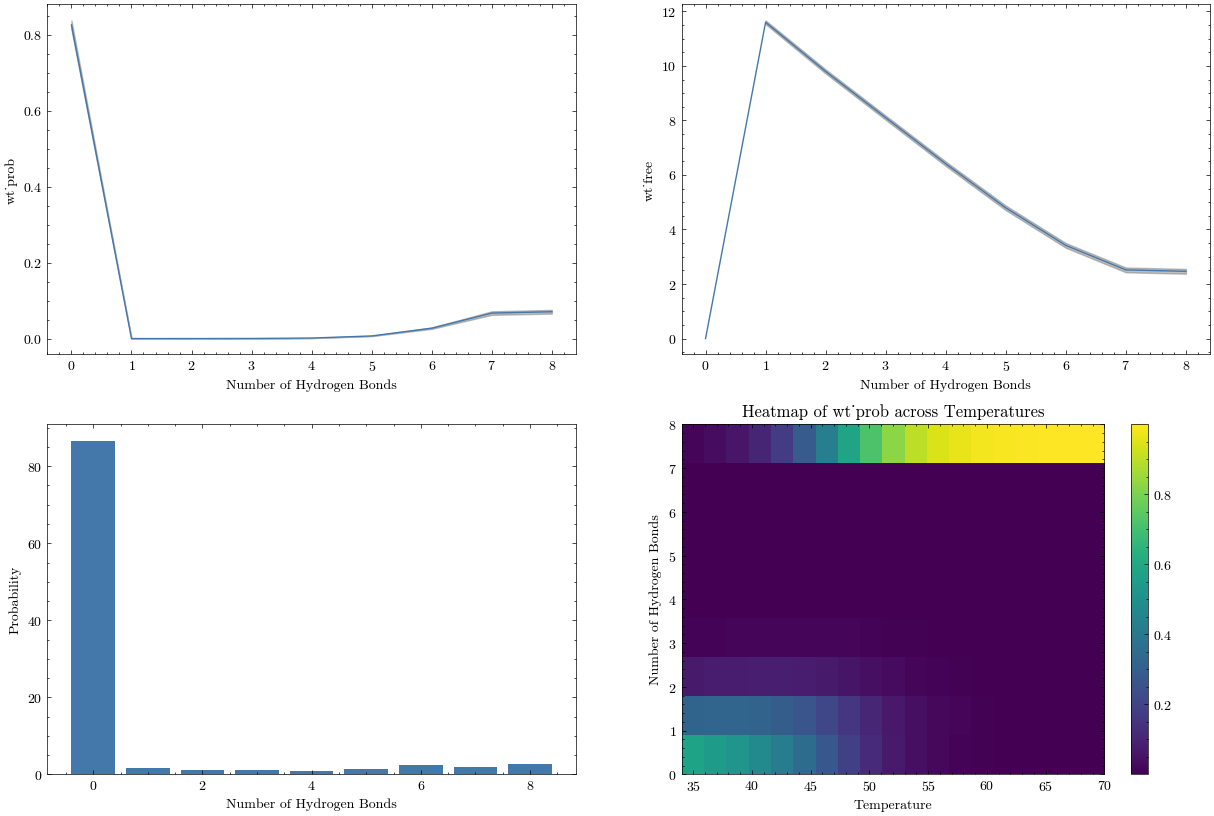

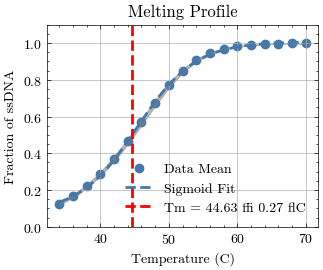

In [43]:
path = os.path.abspath('/scratch/matthew/ipy_oxDNA/ipy_oxdna_examples')
systems = ['duplex_melting']

file_dir_list = [f'{path}/{sys}' for sys in systems]
sim_dir_list = [f'{file_dir}/vmmc_melting_replicas/vmmc_melting_rep' for sys, file_dir in zip(systems, file_dir_list)]

n_replicas = 40
vmmc_replica_generator = VmmcReplicas()

vmmc_replica_generator.multisystem_replica(
    systems,
    n_replicas,
    file_dir_list,
    sim_dir_list
)
vmmc_sim_list = vmmc_replica_generator.sim_list
queue_of_simulations = vmmc_replica_generator.queue_of_sims

vmmc_replica_generator.statistical_analysis_and_plot()

# Run WHAM

In [243]:
temp_range = np.arange(50, 53, 2)
# temp_range = np.array([52])
n_bins = 400
xmin = 0
xmax = 15
max_hb = 8
umbrella_stiff = 5
epsilon = 1e-9
convergence_slice = 1

us_list[0].wham_cont_and_disc_temp_interp_converg_analysis(convergence_slice, temp_range,
                                                           n_bins, xmin, xmax, umbrella_stiff, max_hb,
                                                           epsilon=epsilon, reread_files=False)

temp_idx=0
temp_idx=1


WHAM | 13000/? [00:04<00:00, 2752.91it/s, Convergence: 0.0000000015 / 1e-09]
/scratch/matthew/ipy_oxDNA/ipy_oxdna/umbrella_sampling.py:1241: RuntimeWarning: divide by zero encountered in log
  free = -np.log(p_x)


Converged in [13440] iterations
50.0


/home/matthew/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


# Debug WHAM calculations

In [241]:
com_values = us_list[0].wham_temperature_interpolation(temp_range, n_bins, xmin, xmax, umbrella_stiff, max_hb, epsilon=1e-7, reread_files=False, all_observables=False, max_iterations=100000)

temp_idx=0
temp_idx=1


WHAM | 8000/? [00:02<00:00, 2822.11it/s, Convergence: 0.00000011 / 1e-07]

Converged in [8088] iterations


In [233]:
com_values.shape

(56, 21631)

In [223]:

def molar_concentration_to_box_size(molcon):
    box = ((2/(molcon*6.0221415*10**23))**(1/3)) / 8.5179*10.0**(9)
    return box

molcon = [1, 1e-3, 1e-6, 1e-9, 1e-12]

list(map(molar_concentration_to_box_size, molcon))

[1.7515685666401004,
 17.515685666401,
 175.15685666401,
 1751.5685666400996,
 17515.685666400994]

In [ ]:
def volume_correction(box_size):
    return np.log((((box_size / 2) * np.sqrt(3))**3) / ((4/3) * np.pi * (self.box_size / 2)**3))

In [213]:
truncated_umbrella_bias[0] *2 / 16

0        0.007625
1        0.000702
2        0.001824
3        0.000987
4        0.005346
           ...   
21626    0.007960
21627    0.012165
21628    0.002582
21629    0.000693
21630    0.004012
Name: com_distance, Length: 21631, dtype: float64

In [211]:
[inner_list['force_energy_0'] + inner_list['force_energy_1'] for inner_list in truncated_force_energy][0]

0        0.007627
1        0.000703
2        0.001825
3        0.000988
4        0.005346
           ...   
21626    0.007964
21627    0.012164
21628    0.002584
21629    0.000695
21630    0.004012
Length: 21631, dtype: float64

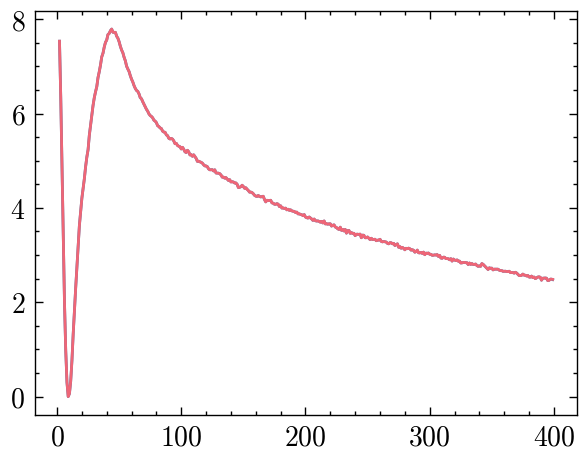

In [205]:
plt.figure(dpi=200)
plt.plot(free_per[0])
plt.plot(free_changed[0])

# Plot continuous, discrete, and melting curves

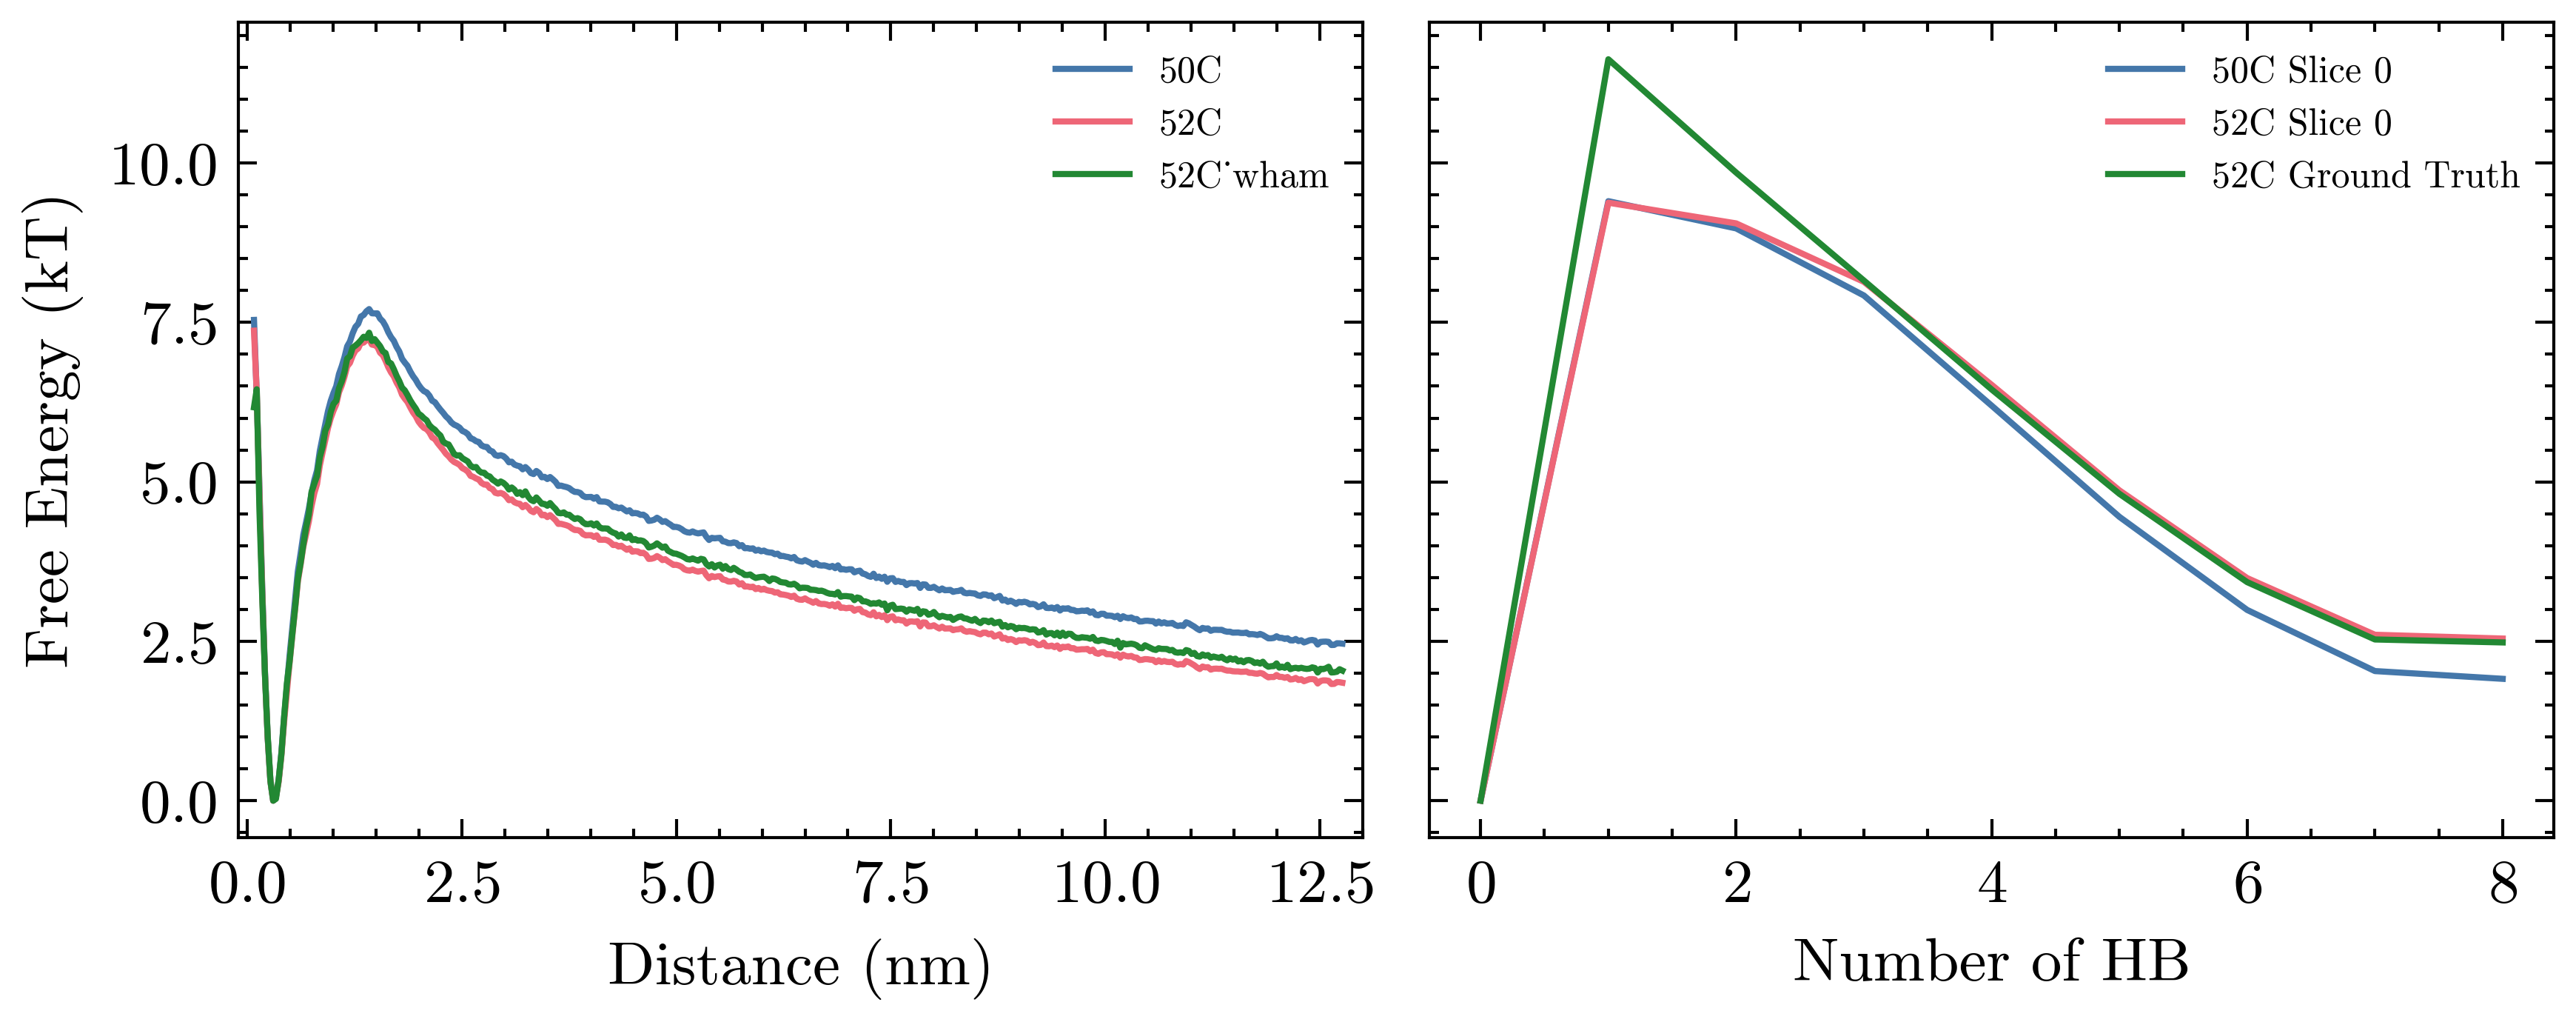

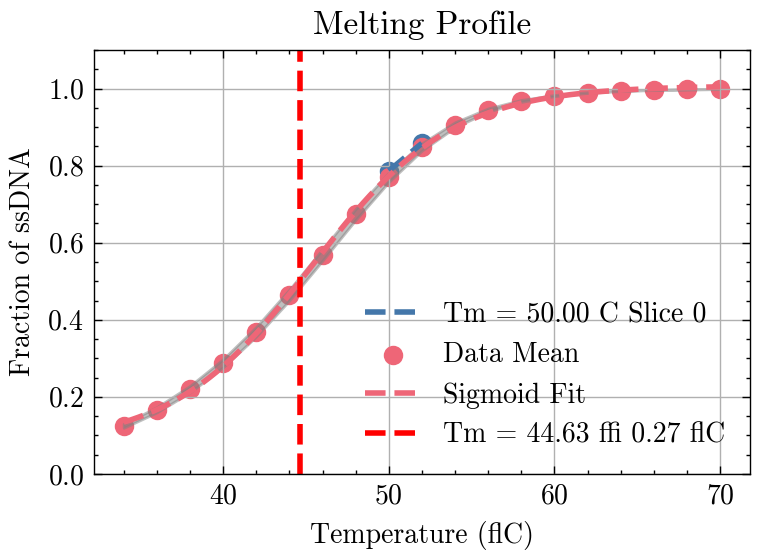

In [244]:

calculated_bin_centers, bin_edges = us_list[0].get_bins(xmin, xmax, n_bins=n_bins)

fig, (ax1, ax2) = plt.subplots(1,2, dpi=600, figsize=(6,2.5), sharey=True, tight_layout=True)
fig, ax = plt.subplots(dpi=200, figsize=(4,3), tight_layout=True)

ax1.set_xlabel('Distance (nm)')
ax2.set_xlabel('Number of HB')

ax1.set_ylabel('Free Energy (kT)')
# ax2.set_ylabel('Free Energy (kT)')
for idx, free in enumerate(us_list[0].convergence_free):            
    sub_index = free[0].argmin()
    for f, temp_val in zip(free, temp_range):
        if idx == 0:
            ax1.plot(calculated_bin_centers*0.8518, f - f[sub_index], label=f'{temp_val}C') 
        else:
            ax1.plot(calculated_bin_centers*0.8518, f - f[sub_index])
for us in us_list:
    us.wham.plot_free_energy(ax=ax1, label='52C_wham')
# vmmc_replica_generator.plot_mean_free_energy_with_error_bars(num_bins=200, ax=ax1)
ax1.set_xlim(-0.1, 13)
        
ax1.legend(fontsize=6)


for idx, free_discrete in enumerate(us_list[0].convergence_discrete_free_energy):
    for f_discrete, temp_val in zip(free_discrete, temp_range):
        ax2.plot(range(9), f_discrete - f_discrete[0], label=f'{temp_val}C Slice {idx}')
ax2.plot(range(9), vmmc_replica_generator.sim_list[0].statistics['wt_occ_52.0C_free']- vmmc_replica_generator.sim_list[0].statistics['wt_occ_52.0C_free'][0], label='52C Ground Truth')
ax2.legend(fontsize=6)

label = ''

for idx, (inverted_finfs, x_fit, y_fit, Tm) in enumerate(zip(us_list[0].convergence_inverted_finfs, us_list[0].convergence_x_fit, us_list[0].convergence_y_fit, us_list[0].convergence_Tm)):
    ax.scatter(temp_range, inverted_finfs, marker='o')
    ax.plot(x_fit, y_fit, linestyle='--', linewidth=2, label=f'Tm = {Tm:.2f} C Slice {idx}')
    # ax.axvline(x=Tm, color='r', linestyle='--', linewidth=2, label=f'{label}Tm = {Tm:.2f} °C')
    ax.legend()   
vmmc_replica_generator.plot_melting_curve(ax=ax)